# Data Set Information:

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

Notes:

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.



# Attribute Information:

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor


We will follow this general procedure for modeling time series:

Plot the time series. Look for trends, seasonality, and step changes.
Model and remove drift and seasonal components.
Fit a model to the residuals.
Add drift and seasonality back into the model.

The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

In [3]:
# loading the dataset.
HusHoldElec = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]})


In [4]:
# Copy of original data
HusHoldElec_original=HusHoldElec.copy()

In [5]:
HusHoldElec.columns

Index(['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [6]:
HusHoldElec.dtypes

datetime                 datetime64[ns]
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [7]:
#print(HusHoldElec.shape)
#print(HusHoldElec.head())

In [8]:
# mark all missing values
HusHoldElec.replace('?', np.nan, inplace=True)


In [9]:
HusHoldElec.isnull().sum()

datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [10]:
#HusHoldElec.head(), HusHoldElec.tail()

In [11]:
# Start and end date for train. The code below works provided we change the 'datetime' is not index column.
#HusHoldElec['datetime'].min(),HusHoldElec['datetime'].max()

In [12]:
# save in csv file format
HusHoldElec.to_csv('household_power_consumption.csv')

In [13]:
HusHoldElec.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [14]:
# load the new file
HusHoldElec = pd.read_csv('household_power_consumption.csv', header=0)
print(HusHoldElec.head())



   Unnamed: 0             datetime  Global_active_power  \
0           0  2006-12-16 17:24:00                4.216   
1           1  2006-12-16 17:25:00                5.360   
2           2  2006-12-16 17:26:00                5.374   
3           3  2006-12-16 17:27:00                5.388   
4           4  2006-12-16 17:28:00                3.666   

   Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  \
0                  0.418   234.84              18.4             0.0   
1                  0.436   233.63              23.0             0.0   
2                  0.498   233.29              23.0             0.0   
3                  0.502   233.74              23.0             0.0   
4                  0.528   235.68              15.8             0.0   

   Sub_metering_2  Sub_metering_3  
0             1.0            17.0  
1             1.0            16.0  
2             2.0            17.0  
3             1.0            17.0  
4             1.0            17.0  


In [15]:
# load the new file
#HusHoldElec = pd.read_csv('household_power_consumption.csv', header=0)
#print(HusHoldElec.head())


<Figure size 432x288 with 0 Axes>

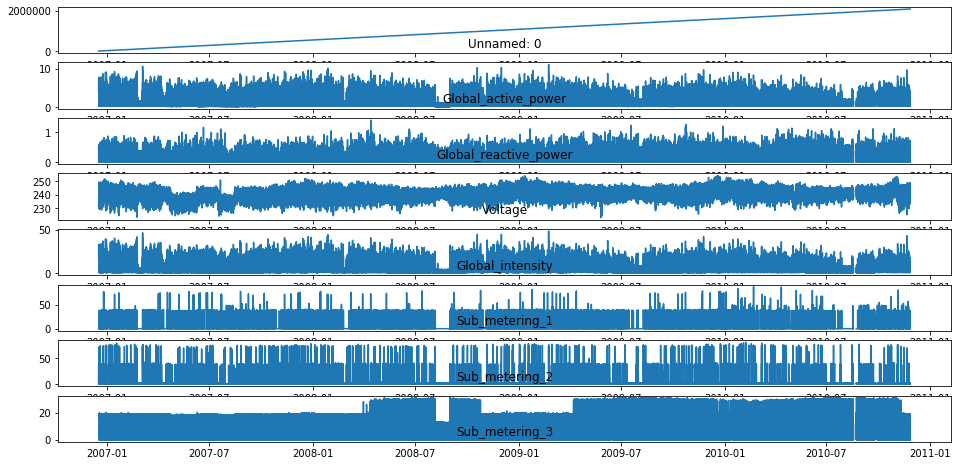

In [16]:
dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

plt.figure()
plt.figure(figsize=(16,8))
for i in range(len(dataset.columns)):
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    plt.plot(dataset[name])
    plt.title(name, y=0)
plt.show()

In [17]:
''' Grouping the dataset by month, day, hour. This type of grouping is not good. Becasue we have to be carfeul
      on the exact dates which we are going to group.'''

df_m = dataset.groupby(pd.Grouper(freq='m')).mean() 
df_d = dataset.groupby(pd.Grouper(freq='d')).mean() 
df_h = dataset.groupby(pd.Grouper(freq='h')).mean() 


In [18]:
#df.head()

<Figure size 432x288 with 0 Axes>

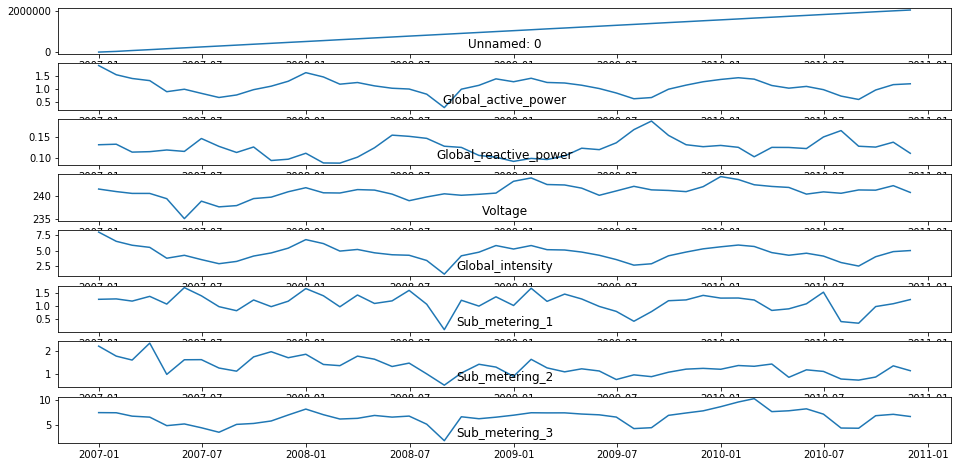

In [19]:
#Plot of  the dataset grouped by by month.
plt.figure()
plt.figure(figsize=(16,8))
for i in range(len(df_m.columns)):
    plt.subplot(len(df_m.columns), 1, i+1)
    name = df_m.columns[i]
    plt.plot(df_m[name])
    plt.title(name, y=0)
plt.show()

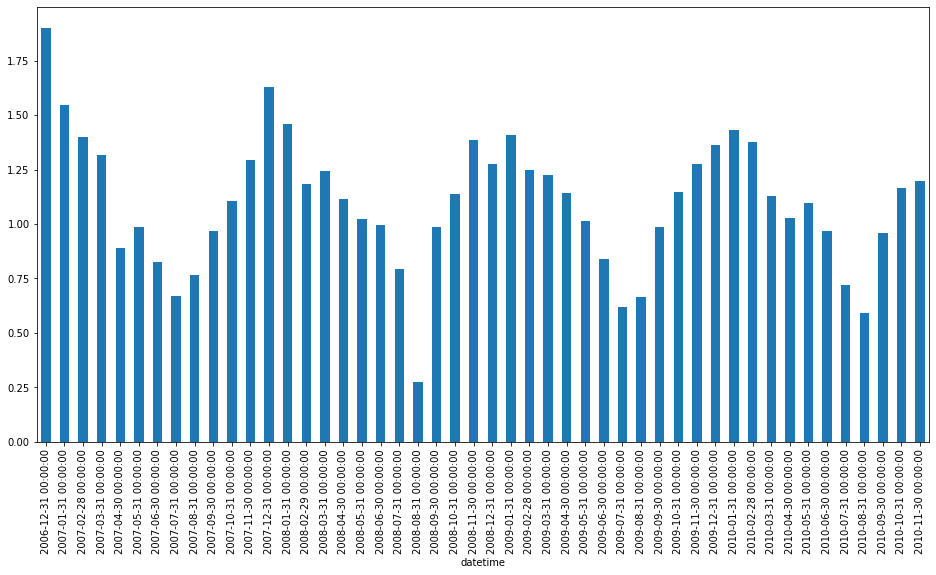

In [20]:
# We only need the Global_active_power, which is the total power consumed in the house hold per day.
plt.figure(figsize=(16,8))
df_m['Global_active_power'].plot.bar()

<Figure size 432x288 with 0 Axes>

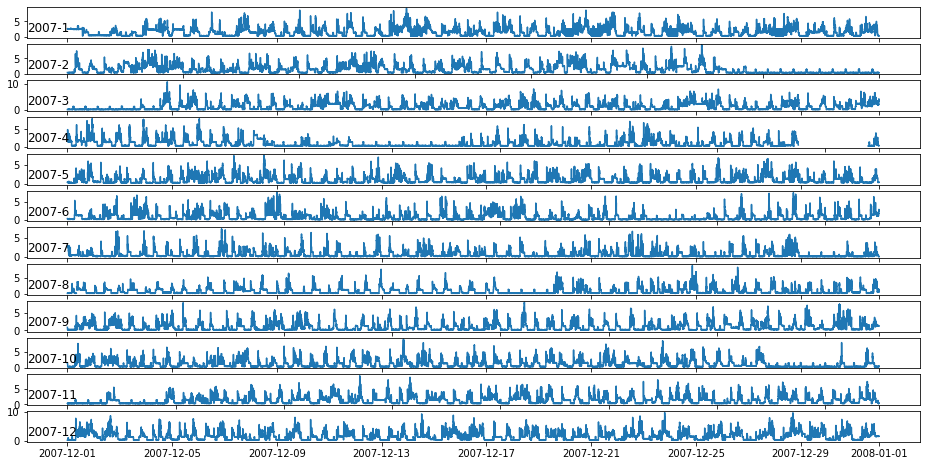

In [21]:


# monthly line plots

months = [x for x in range(1, 13)]
plt.figure()
plt.figure(figsize=(16,8))
for i in range(len(months)):
    #prepare subplot
    ax = plt.subplot(len(months), 1, i+1)
    # determine the month to plot
    month = '2007-' + str(months[i])
    # get all observations for the month
    result = dataset[month]
    # plot the active power for the month
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(month, y=0, loc='left')
plt.show()


<Figure size 432x288 with 0 Axes>

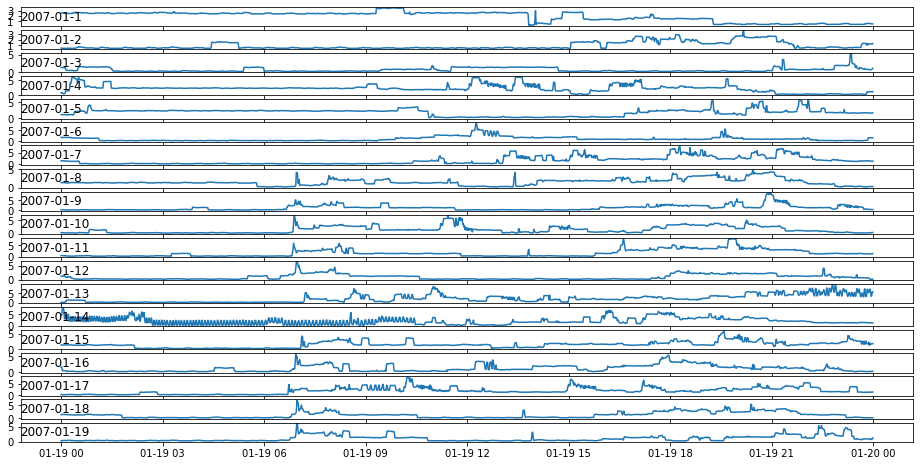

In [22]:
# daily  plot active power for each year
days = [x for x in range(1, 20)]
plt.figure()
plt.figure(figsize=(16,8))
for i in range(len(days)):
    #prepare subplot
    ax = plt.subplot(len(days), 1, i+1)
    # determine the month to plot
    day = '2007-01-' + str(days[i])
    # get all observations for the month
    result = dataset[day]
    # plot the active power for the month
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(day, y=0, loc='left')
plt.show()


<Figure size 432x288 with 0 Axes>

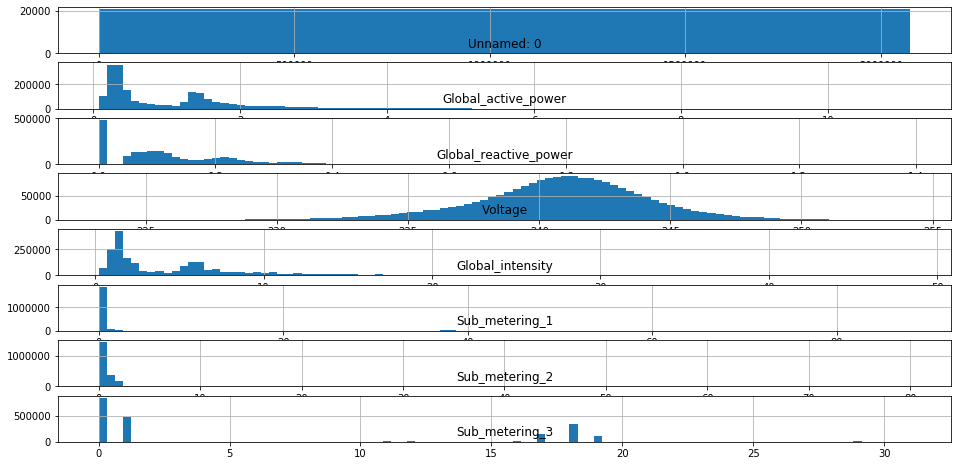

In [23]:
#Time Series Data Distributions
# histogram plot for each variable
plt.figure()
plt.figure(figsize=(16,8))
for i in range(len(dataset.columns)):
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    dataset[name].hist(bins=100)
    plt.title(name, y=0)
plt.show()

<Figure size 432x288 with 0 Axes>

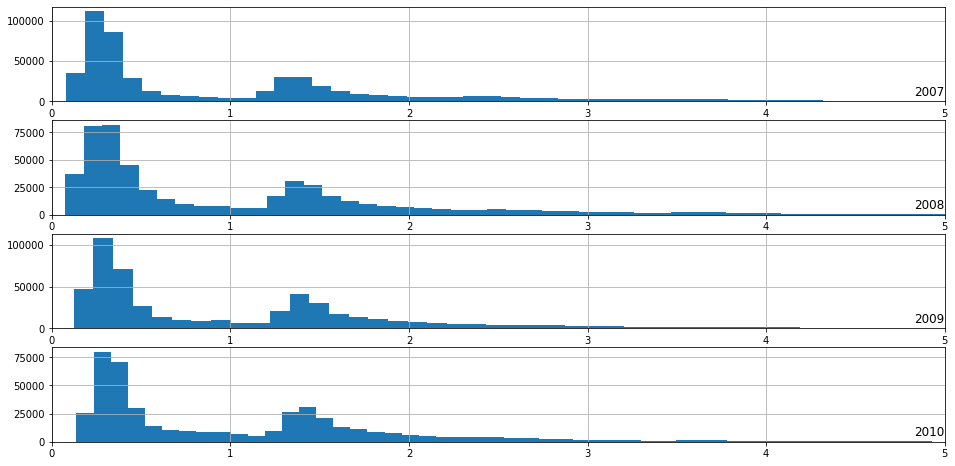

In [24]:
# plot active power for each year
years = ['2007', '2008', '2009', '2010']
plt.figure()
plt.figure(figsize=(16,8))
for i in range(len(years)):
    # prepare subplot
    ax = plt.subplot(len(years), 1, i+1)
    # determine the year to plot
    year = years[i]
    # get all observations for the year
    result = dataset[str(year)]
    # plot the active power for the year
    result['Global_active_power'].hist(bins=100)
    # zoom in on the distribution
    ax.set_xlim(0, 5)
    # add a title to the subplot
    plt.title(str(year), y=0, loc='right')
plt.show()

In [25]:
# mark all missing values
dataset.replace('?', np.nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')


In [26]:
# fill missing values with a value at the same time one day ago.
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [27]:
# fill missing
fill_missing(dataset.values)

In [28]:
#dataset.drop(['Unnamed: 0'], axis = 1)

In [29]:
#Grouping the dataset by month, day, hour. We don't use this.
df_mm = dataset.groupby(pd.Grouper(freq='m')).sum() 
df_dd = dataset.groupby(pd.Grouper(freq='d')).sum() 
df_hh = dataset.groupby(pd.Grouper(freq='h')).sum() 

In [30]:
#df_dd.head()

Another way of to achieve this easily using the resample() function on the pandas DataFrame. Calling this function with the argument ‘D‘ allows the loaded data indexed by date-time to be grouped by day (see all offset aliases). We can then calculate the sum of all observations for each day and create a new dataset of daily power consumption data for each of the eight variables.

In [31]:
# resample data to hourly
hourly_groups = dataset.resample('H')
hourly_data = hourly_groups.sum()
# resample data to weekly
weekly_groups = dataset.resample('W')
weekly_data = weekly_groups.sum()


# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()

# resample data to monthly
monthly_groups = dataset.resample('M')
monthly_data = monthly_groups.sum()
# summarize

print(hourly_data.shape)
print(daily_data.shape)
print(weekly_data.shape)
print(monthly_data.shape)


# save
hourly_data.to_csv('household_power_consumption_hourly.csv')
daily_data.to_csv('household_power_consumption_daily.csv')
weekly_data.to_csv('household_power_consumption_wekly.csv')
monthly_data.to_csv('household_power_consumption_months.csv')


(34589, 8)
(1442, 8)
(207, 8)
(48, 8)


In [32]:
#hourly_data["Global_active_power"]

In [33]:
# Prediction with ARIMA : AutoRegressive Integrated Moving Average. 

In [34]:
# split a univariate dataset into train/test sets
# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

def split_dataset(data):
    #split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

datasett = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'])#, index_col=['datetime'])
#datasett = datasett.drop(["Unnamed: 0", "datetime"], axis = 1)
datasett = datasett.drop("Unnamed: 0", axis = 1)
#y=datasett['Global_active_power']
#X=datasett[['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
#X_train,y_train, X_test, y_test = split_dataset(datasett.values)
train, test= split_dataset(datasett.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
2006-12-17 00:00:00 2010-01-02 00:00:00
(46, 7, 8)
2010-01-03 00:00:00 2010-11-20 00:00:00


#1. Stationarity of a Time Series

Stationarity of a Time Series¶

There are three basic criterion for a time series to understand whether it is stationary series or not.
Statistical properties of time series such as mean, variance should remain constant over time to call time series is
stationary

constant mean

constant variance

autocovariance that does not depend on time. 

Autocovariance is covariance between time series and lagged time series.
Lets visualize and check seasonality trend of our time series.

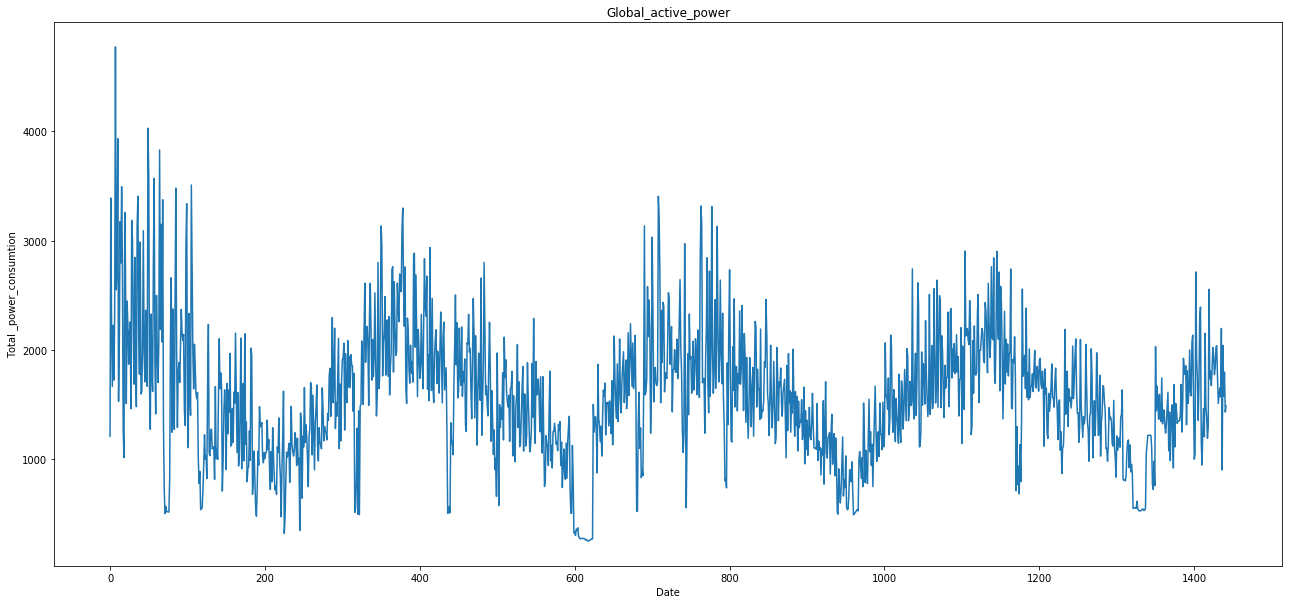

In [35]:

plt.figure(figsize=(22,10))
#Datasette = datasett["Global_active_power"]
plt.plot(datasett.Global_active_power)
plt.title("Global_active_power")
plt.xlabel("Date")
plt.ylabel("Total _power_consumtion")
plt.show()

# lets create time series from weather 
timeSeries = datasett.loc[:, ["datetime","Global_active_power"]]
timeSeries.index = timeSeries.datetime
tss = timeSeries.drop("datetime",axis=1)

As you can see from plot above, our time series has seasonal variation. 

. Now lets check stationary of time series. We can check stationarity using the following methods:

1. Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.

2. Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary.

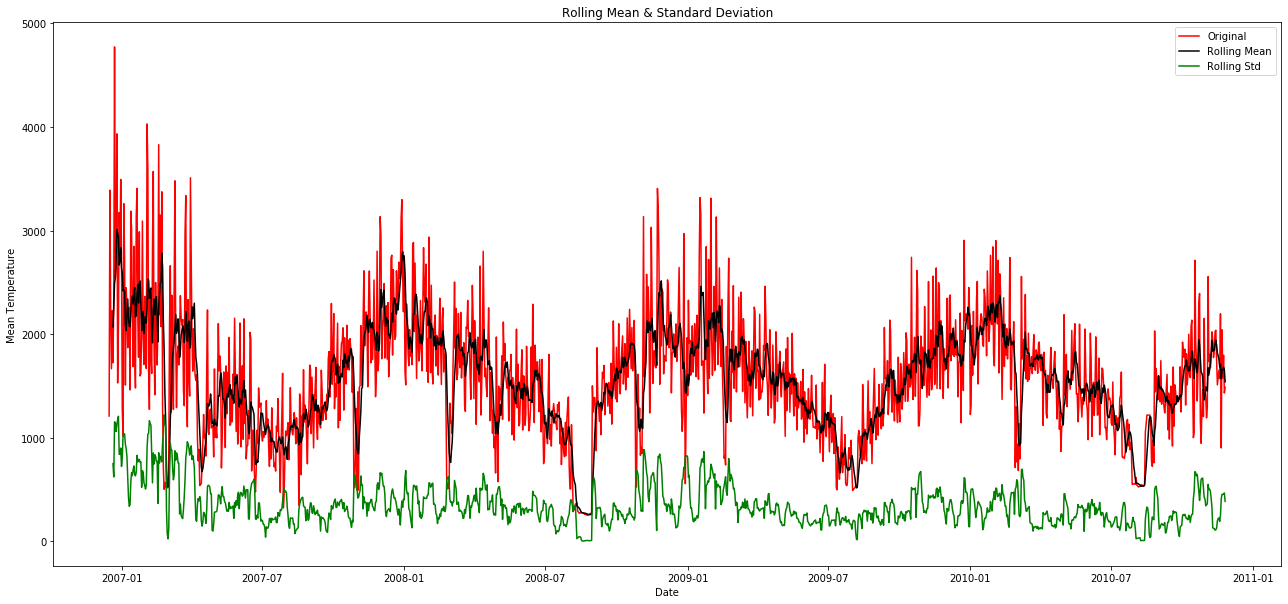

Test statistic:  -3.6973847019519175
p-value:  0.0041500913950943625
Critical Values: {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}


In [36]:
# adfuller library 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import logging as log
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    #rolmean = pd.rolling_mean(ts, window=6)
    rolmean = ts.rolling(6).mean()
    #moving_avg = ts_log.rolling(12).mean()
    #rolstd = pd.rolling_std(ts, window=6)
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std)and adfuller test
check_mean_std(tss)
check_adfuller(tss.Global_active_power)

In [37]:
#print(pd.__version__) checking pandas version.

From the graph we can conclude that.

1. As we can see from the black graph we can see that mean is not constant  whihc is the first critearon for stationarity.(no stationary)

2. Variance looks like constant. (yes stationary)

3. The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a   
    stationary series. (yes stationary)

We have stationary time series. However lets look at one more method to avoid trend and seasonality.

Differencing method: It is one of the most common method. Idea is that take difference between time series and shifted time series.

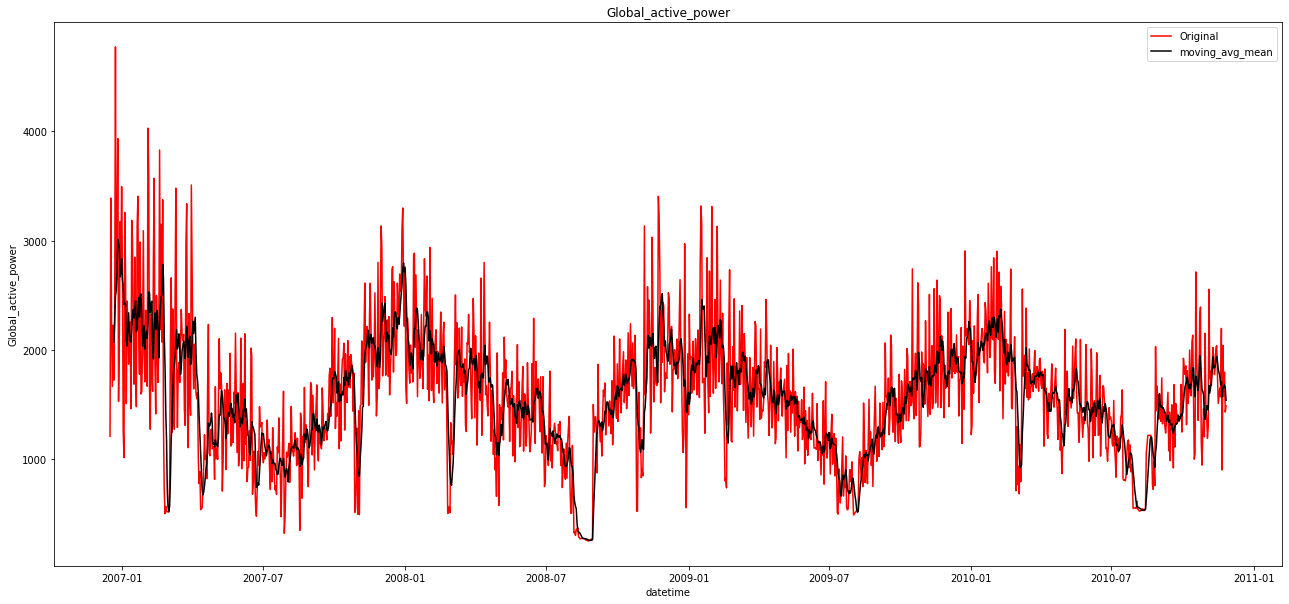

In [38]:
# Moving average method
window_size = 6
#moving_avg = pd.rolling_mean(ts,window_size)
moving_avg =tss.rolling(window_size).mean()
plt.figure(figsize=(22,10))
plt.plot(tss, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Global_active_power")
plt.xlabel("datetime")
plt.ylabel("Global_active_power")
plt.legend()
plt.show()

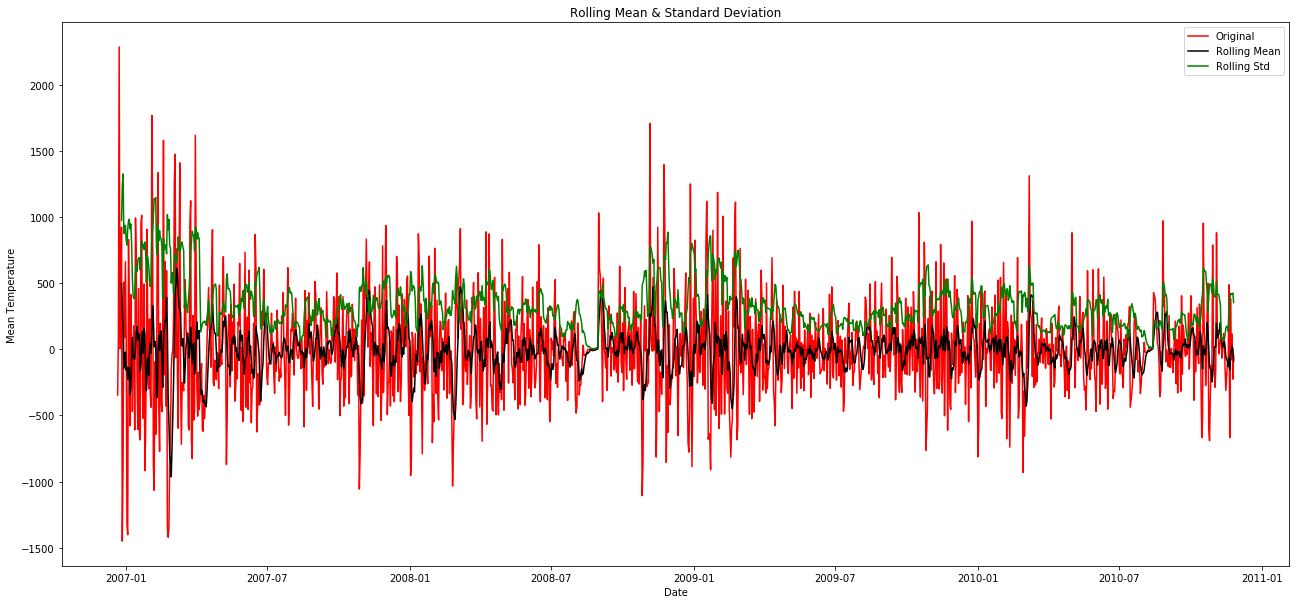

Test statistic:  -9.91196193301024
p-value:  3.151754694560173e-17
Critical Values: {'1%': -3.4349863902854607, '5%': -2.863587640846308, '10%': -2.567860154259632}


In [39]:
ts_moving_avg_diff = tss - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 6 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff.Global_active_power)

1. Constant mean criteria: mean looks like constant as you can see from plot(black line) above . (yes stationary)
2. Constant variance. It looks like constant. (yes stationary)
3. The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)

We achieve stationary time series. However lets look at one more method to avoid trend and seasonality.

Differencing method: It is one of the most common method. Idea is that take difference between time series and shifted time series.

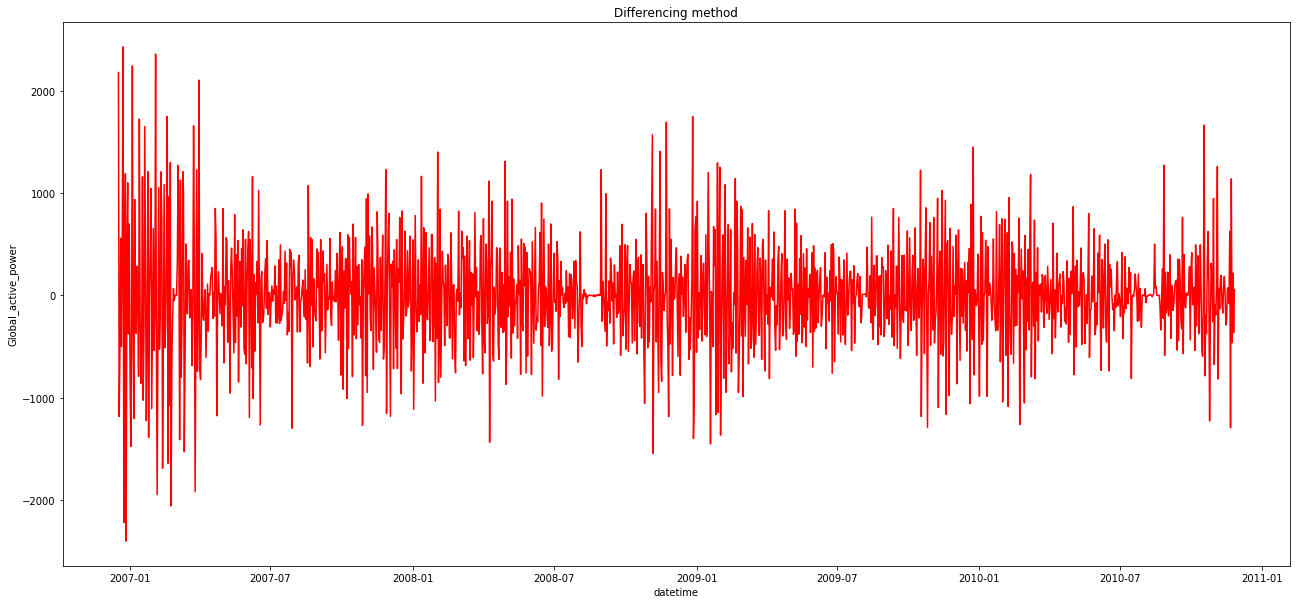

In [40]:
# differencing method
ts_diff = tss - tss.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff, color='red' )
plt.title("Differencing method") 
plt.xlabel("datetime")
plt.ylabel("Global_active_power")
plt.show()

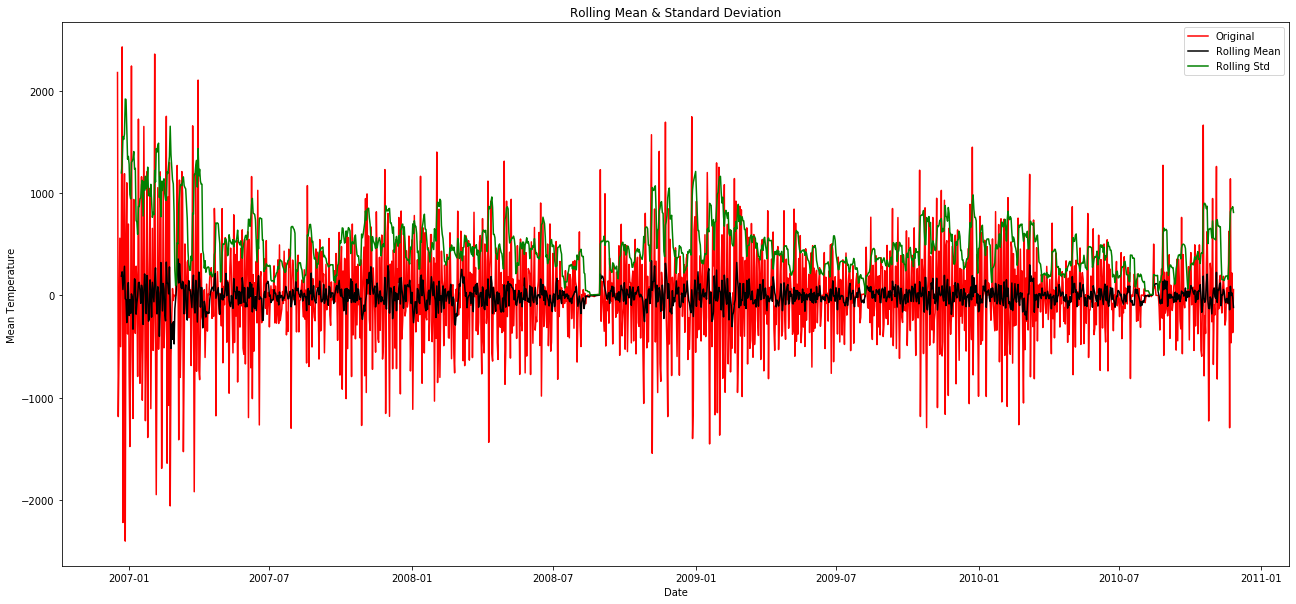

Test statistic:  -11.054245341865638
p-value:  4.990970366961645e-20
Critical Values: {'1%': -3.434966750462565, '5%': -2.8635789736973725, '10%': -2.5678555388041384}


In [41]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff.Global_active_power)

1. Constant mean criteria: mean looks like constant as you can see from plot(black line) above . (yes stationary)
2. Constant variance. It looks like constant. (yes stationary)
3. The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)

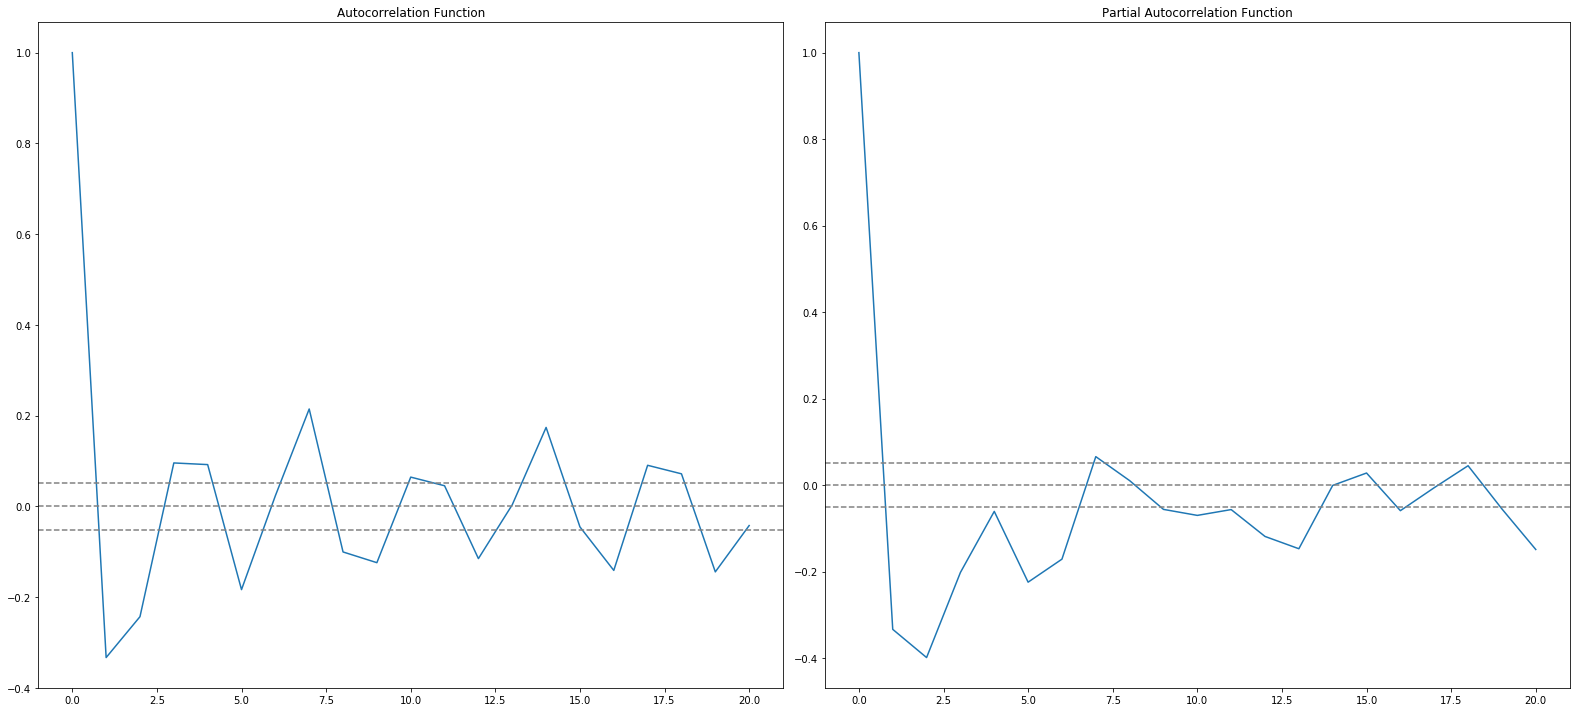

In [42]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/teshomeb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


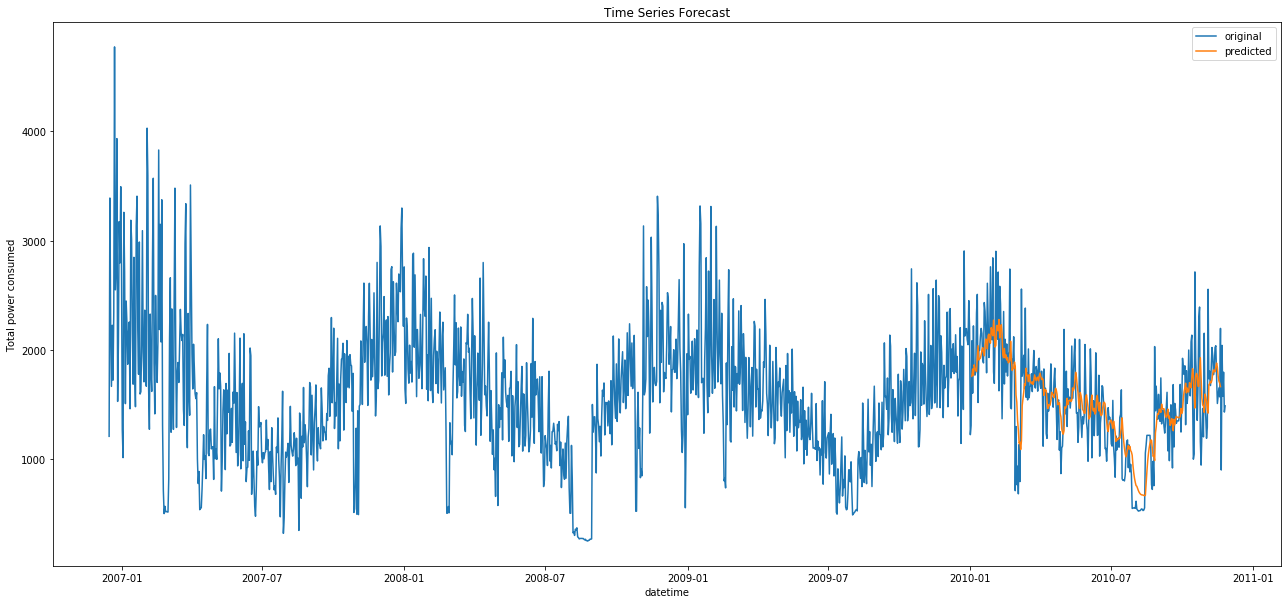

In [43]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(tss, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit(disp=0)

# predict
start_index = datetime(2010, 1, 3)
end_index = datetime(2010, 11, 20)
forecast = model_fit.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.plot(datasett.datetime,datasett.Global_active_power,label = "original")

plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("datetime")
plt.ylabel("Total power consumed")
plt.legend()
plt.show()

/Users/teshomeb/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error:  195390.36962567273


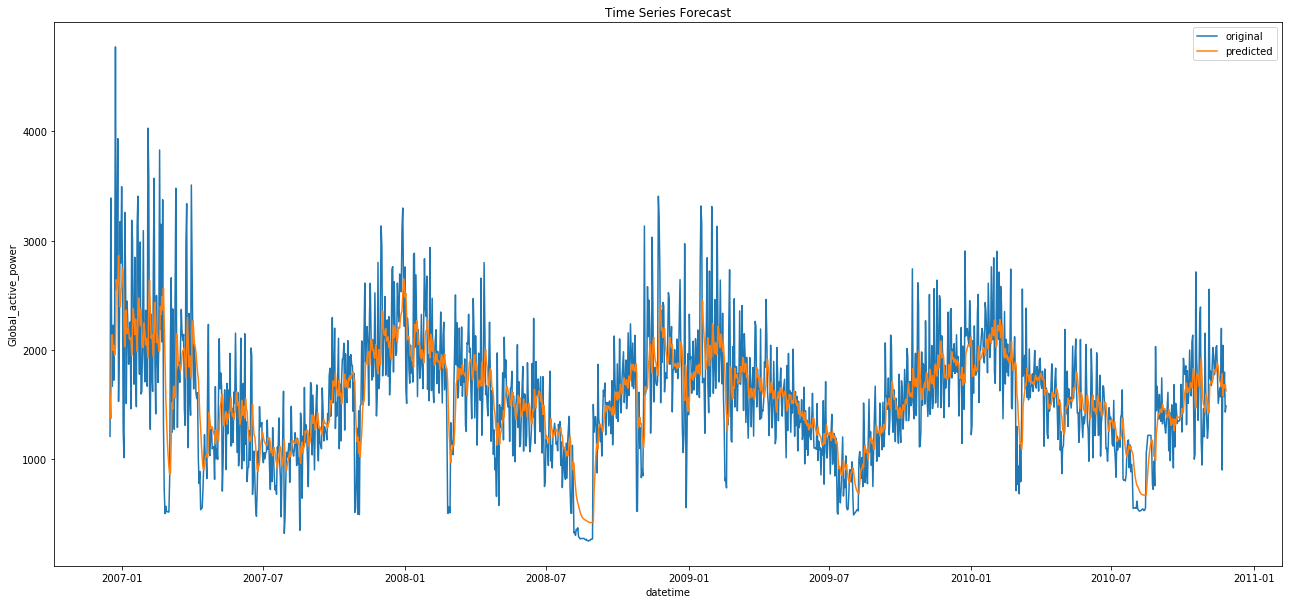

In [44]:
# predict all path
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(tss, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit(disp=0)
forecast2 = model_fit2.predict()
error = mean_squared_error(tss, forecast2)
print("error: " ,error)
# visualization
plt.figure(figsize=(22,10))
plt.plot(datasett.datetime,datasett.Global_active_power,label = "original")
plt.plot(forecast2,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("datetime")
plt.ylabel("Global_active_power")
plt.legend()
plt.savefig('graph.png')

plt.show()

In [45]:
#train

my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 12)
# define model
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order, ...)

model_fit = model.fit()

hatt = model_fit.predict(start=len(train), end=len(train))

In [46]:
#hatt

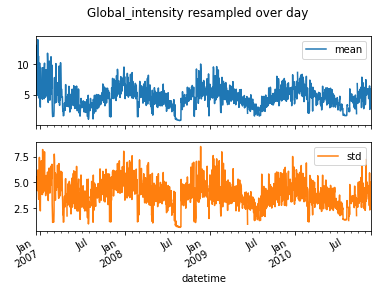

<Figure size 1440x720 with 0 Axes>

In [47]:
r = dataset.Global_intensity.resample('D').agg(['mean', 'std'])

r.plot(subplots = True, title='Global_intensity resampled over day')
plt.figure(figsize=(20,10))
plt.show()

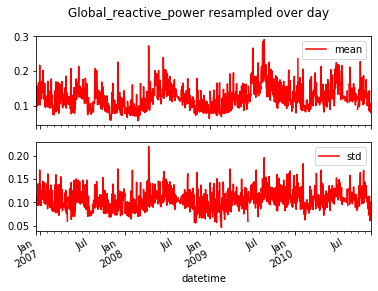

In [48]:

r2 = dataset.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

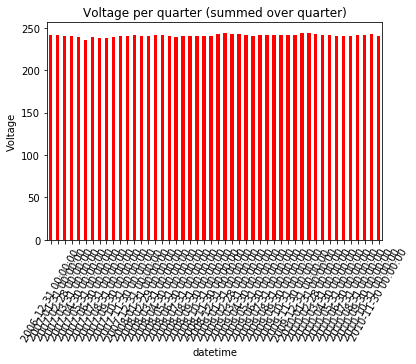

In [49]:
dataset['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

In [205]:
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [225]:
#hourly_data

In [51]:
#hr_dt-GAP=hourly_data('Global_active_power', axis=1)

In [52]:
 #hr_dt1 = hourly_data.drop('Global_active_power', axis =1)

In [174]:
X= hourly_data.drop(['Unnamed: 0', 'Global_active_power'], axis=1 )

In [175]:
y= hourly_data['Global_active_power']

In [176]:
ser_y=y.values

In [177]:
ser_X=X.values

In [178]:
ser_yy= ser_y.reshape(-1, 1)

In [179]:
ser_yy

array([[152.024  ],
       [217.932  ],
       [204.01399],
       ...,
       [ 99.56   ],
       [ 69.822  ],
       [  2.804  ]], dtype=float32)

In [180]:
ser_X=X.values

In [181]:
ser_XX=ser_X.reshape(-1, 6)

In [224]:
#ser_XX

In [183]:
MIN_MAX=MinMaxScaler(feature_range = (0, 1))

In [184]:

ser_y_scaled = MIN_MAX.fit_transform(ser_yy)


In [185]:
ser_X_scaled = MIN_MAX.fit_transform(ser_XX)

In [186]:
ser_X_scaled.shape

(34589, 6)

# Spliting data  in to training and testing  data set.
The given data set is splitted in to training and testing data set with ratio: training 75% and test 25 %.

In [191]:
train_size = int(len(X) * 0.75)
X_train, X_test = ser_X_scaled[0:train_size],ser_X_scaled[train_size:len(X)]
y_train, y_test = ser_y_scaled[0:train_size], ser_y_scaled[train_size:len(X)]

In [201]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25941, 6), (25941, 1), (8648, 6), (8648, 1))

## RNN

# Model architecture

1) LSTM with 100 neurons in the first visible layer

3) dropout 20%

4) 1 neuron in the output layer for predicting Global_active_power.

5) The input shape will be 1 time step with 7 features.

6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.




In [203]:
# reshape input to be 3D [samples, timesteps, features]
X_trainn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_testt = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
#test_X =X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_trainn.shape, y_train.shape, X_testt.shape, y_test.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(25941, 1, 6) (25941, 1) (8648, 1, 6) (8648, 1)


In [212]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_trainn.shape[1], X_trainn.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(.75))
#    model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



Train on 25941 samples, validate on 8648 samples
Epoch 1/20
 - 4s - loss: 7.6335e-05 - val_loss: 2.5251e-05
Epoch 2/20
 - 4s - loss: 7.5836e-05 - val_loss: 4.0241e-05
Epoch 3/20
 - 4s - loss: 7.4237e-05 - val_loss: 2.1510e-05
Epoch 4/20
 - 4s - loss: 7.2580e-05 - val_loss: 2.1115e-05
Epoch 5/20
 - 4s - loss: 7.1608e-05 - val_loss: 2.3142e-05
Epoch 6/20
 - 4s - loss: 7.0667e-05 - val_loss: 1.8850e-05
Epoch 7/20
 - 4s - loss: 7.2682e-05 - val_loss: 2.9733e-05
Epoch 8/20
 - 4s - loss: 7.1309e-05 - val_loss: 1.5080e-05
Epoch 9/20
 - 4s - loss: 7.4118e-05 - val_loss: 3.6488e-05
Epoch 10/20
 - 4s - loss: 7.3831e-05 - val_loss: 1.4203e-05
Epoch 11/20
 - 4s - loss: 7.0412e-05 - val_loss: 2.2577e-05
Epoch 12/20
 - 4s - loss: 6.9751e-05 - val_loss: 2.1665e-05
Epoch 13/20
 - 4s - loss: 7.3381e-05 - val_loss: 1.6767e-05
Epoch 14/20
 - 4s - loss: 7.0978e-05 - val_loss: 2.0709e-05
Epoch 15/20
 - 4s - loss: 7.0064e-05 - val_loss: 1.6226e-05
Epoch 16/20
 - 4s - loss: 6.7487e-05 - val_loss: 3.1124e-05


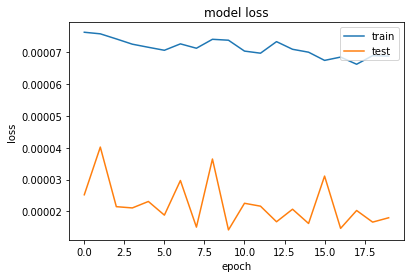

In [216]:
# fit network
history = model.fit(X_trainn, y_train, epochs=20, batch_size=70, validation_data=(X_testt, y_test), 
                    verbose=2, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [220]:
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

In [223]:
# make a prediction
yhat = model.predict(X_testt)
X_test = X_testt.reshape((X_testt.shape[0], 6))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, -5:]), axis=1)
inv_yhat = MIN_MAX.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -5:]), axis=1)
inv_y = MIN_MAX.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.197
